In [108]:
# Imports 
import pandas as pd
import numpy as np 
import scipy.stats as st
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

## Data Prep

To solve the problem, first a single call / put price must be taken into account per strike. The approach is to use market mids as the option prices. 

In [13]:
# Data 
dat_file = 'quotedata.dat'
df = pd.read_csv(dat_file, skiprows=2, header=0)
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])

# Add market mids
df['Call_mid'] = (df['CBid'] + df['CAsk']) / 2
df['Put_mid'] = (df['PBid'] + df['PAsk']) / 2

# Add time to maturity
quote_date = datetime(2019, 2, 8)
spy_spot = 2707.88
def calculate_tau(expiration_date, quote_date=quote_date):
    tau = (expiration_date - quote_date).days / 365.0
    return tau

df['tau'] = df['Expiration Date'].apply(lambda x: calculate_tau(x))

## Pricing functions

Different functions used for option pricing and implied volatility estimation. Credits to Lech Grzelak: https://github.com/LechGrzelak/Computational-Finance-Course. The first three functions are used to estimate implied volatilites, using the *Black-Scholes* option pricing formulas, and the *Newton-Raphson* method for root finding. The next two functions are used to calibrate the two missing parameters ($r$ and $q$) using market prices, as well as *Put Call Parity*.

In [71]:
# Volatility functions
def BS_Call_Option_Price(S_0, K, sigma, tau, r=0, q=0, CP="c"):
    d1    = (np.log(S_0 / float(K)) + (r-q + 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    d2    = d1 - sigma * np.sqrt(tau)
    if str(CP).lower()=="c" or str(CP).lower()=="1":
        value = np.exp(-q*tau) * st.norm.cdf(d1) * S_0 - st.norm.cdf(d2) * K * np.exp(-r * tau)
    elif str(CP).lower()=="p" or str(CP).lower()=="-1":
        value = st.norm.cdf(-d2) * K * np.exp(-r * tau) - st.norm.cdf(-d1)*S_0*np.exp(-q*tau)
    return value

# Vega, dV/dsigma
def dV_dsigma(S_0,K,sigma,tau,r,q):
    #parameters and value of Vega
    d1    = (np.log(S_0 / float(K)) + (r-q + 0.5 * np.power(sigma,2.0)) * tau) / float(sigma * np.sqrt(tau))
    value = st.norm.pdf(d1) * np.sqrt(tau) * S_0 * np.exp(-q * tau)
    return value

# Implied Vol with Newton - Raphson
def ImpliedVolatility(S_0,K,sigma,tau,r,q, V_market, max_iter=10000, CP="c"):
    error    = 1e10; # initial error
    #Handy lambda expressions
    optPrice = lambda sigma: BS_Call_Option_Price(S_0,K,sigma,tau,r,q,CP)
    vega = lambda sigma: dV_dsigma(S_0,K,sigma,tau,r,q)
    
    # While the difference between the model and the arket price is large
    # follow the iteration
    n = 1.0 
    while error>10e-12 and n<max_iter:
        g = optPrice(sigma) - V_market
        g_prim = vega(sigma)
        sigma_new = sigma - g / (g_prim)
    
        #error=abs(sigma_new-sigma)
        error=abs(g)
        sigma=sigma_new
        
        #print('iteration {0} with error = {1}'.format(n,error))
        
        n= n+1
    return sigma


# Calibrate for r and q 
def put_call_parity(Call, Put, r, q, tau, K, spy_spot):
    lhs = Call - Put
    F = spy_spot * np.exp((r - q)*tau)
    rhs = np.exp(-r*tau)*(F - K)
    diff = lhs - rhs 
    return diff

def objective(params, data, spy_spot=spy_spot):
    r, q = params
    total_squared_error = 0

    for index, row in data.iterrows():
        Call = row['Call_mid']
        Put = row['Put_mid']
        tau = row['tau']
        K = row['Strike']

        diff = put_call_parity(Call, Put, r, q, tau, K, spy_spot)
        total_squared_error += diff ** 2

    return total_squared_error

## Market Implied Interest Rate and Dividend Yield

The following code chunk finds the missing Black-Scholes parameters minimizing the theoretical Put Call parity values vs market-observed.

In [76]:
# Market implied r and q
initial_guess = [0.05, 0.02]
result = minimize(objective, initial_guess, args=(df, spy_spot), method='L-BFGS-B')
if result.success:
    optimized_r, optimized_q = result.x
    print(f"Market implied interest rate (r): {optimized_r}")
    print(f"Market implied dividend yield (q): {optimized_q}")
else:
    print("Optimization failed")

r_imp = optimized_r
q_imp = optimized_q    

Market implied interest rate (r): 0.02687497644389257
Market implied dividend yield (q): 0.021766420970007576


## Implied Volatility estimation

Implied volatilities are found using market observed prices, as well as the previously defined functions. As there are two implied vols per strike (one for call and one for put), the mid is used as the Implied Volatility. 

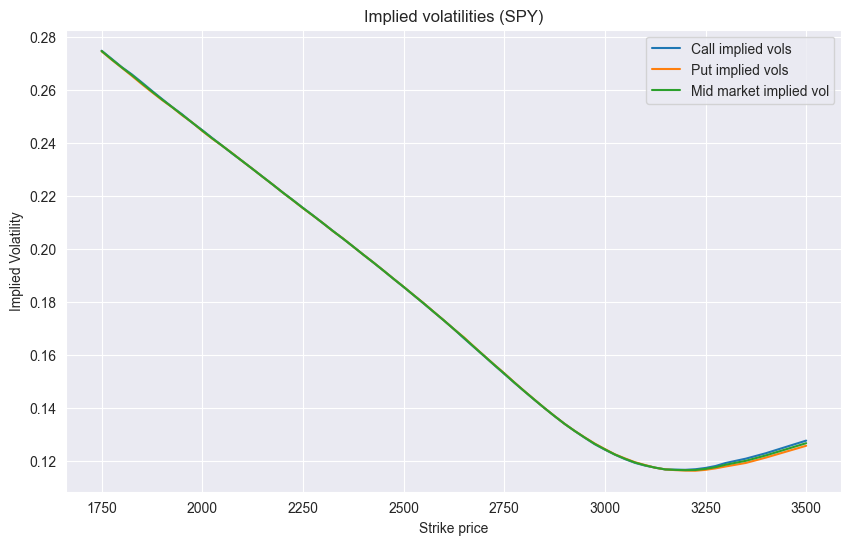

In [110]:
# Call IV
df['call_iv'] = df.apply(lambda row: ImpliedVolatility(S_0=spy_spot, K=row['Strike'], sigma=0.25, tau=row['tau'], r=r_imp, q=q_imp, V_market=row['Call_mid']), axis=1)
df['put_iv'] = df.apply(lambda row: ImpliedVolatility(S_0=spy_spot, K=row['Strike'], sigma=0.25, tau=row['tau'], r=r_imp, q=q_imp, V_market=row['Put_mid'], CP="p"), axis=1)
df['implied_vol'] = (df['call_iv'] + df['put_iv']) / 2

sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))

plt.plot(df['Strike'], df['call_iv'], label='Call implied vols')
plt.plot(df['Strike'], df['put_iv'], label='Put implied vols')
plt.plot(df['Strike'], df['implied_vol'], label='Mid market implied vol')
plt.xlabel('Strike price')
plt.ylabel('Implied Volatility')
plt.title('Implied volatilities (SPY)')
plt.legend()
plt.show()

## SVI Model 

The SVI model is defined as follows: 
$w^2(x) = a + b \left( p (x - m) + \sqrt{(x - m)^2 + s^2} \right)$, where $w^2(x)$ is the estimate for the implied variance under the *SVI Model*. $x$ corresponds to the *Log-Moneyness*, $x = \log\frac{K}{S}$. The following code chunk has the functions used to calibrate (optimize) the SVI model to find the parameters $a, b, p, m, s$ that best fit the observed market smile. 

In [111]:
# SVI Model Fitting 
# x = ln(K/S)
# Formula: var(x) = a + b * (p * (x - m) + sqrt((x - m)**2 + s**2))

def svi_model(a, b, p, m, s, x):
    return a + b * (p * (x - m) + np.sqrt((x - m)**2 + s**2))

def svi_objective(params, x, implied_vol_sq):
    a, b, p, m, s = params
    model_variance = svi_model(a, b, p, m, s, x)
    squared_error = np.sum((model_variance - implied_vol_sq)**2)
    return squared_error

def calibrate_svi(x, implied_vol_sq):
    initial_guess = [0.1, 0.1, 0.0, 0.0, 0.1]

    # Bounds for the parameters: a > 0, b > 0, -1 <= rho <= 1, sigma > 0
    bounds = [(0, None), (0, None), (-1, 1), (None, None), (0, None)]

    # Minimize the objective function to find the best-fit SVI parameters
    result = minimize(svi_objective, initial_guess, args=(x, implied_vol_sq), bounds=bounds)

    if result.success:
        return result.x
    else:
        print("Optimization failed.")
        return None


## Optimization and results

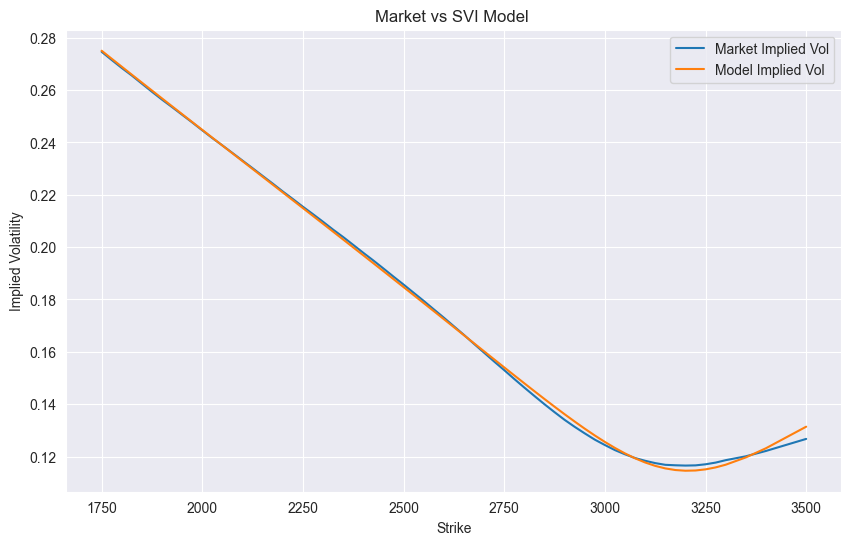

In [112]:
# Optimization 
df['LogMoneyness'] = np.log(df['Strike'] / spy_spot)
df['implied_vol_sq'] = df['implied_vol'] ** 2
svi_params = calibrate_svi(df['LogMoneyness'].values, df['implied_vol_sq'].values)
a, b, p, m, s = svi_params
df['model_iv'] = np.sqrt(df['LogMoneyness'].apply(lambda x: svi_model(a, b, p, m, s, x)))

# Model vs Market
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
plt.plot(df['Strike'], df['implied_vol'], label='Market Implied Vol')
plt.plot(df['Strike'], df['model_iv'], label='Model Implied Vol')
plt.title('Market vs SVI Model ')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()


## Variance Swap Pricing

Using the SVI model, we can price the fair strike of a *Variance Swap*. For this, we use the VIX index calculation. Further details on the derivation can be found in *Mathematical Modeling and Computation in Finance* by Lech Grzelak. The expression for the VIX index is as follows: 

$\text{VIX}^2 = \frac{2}{T - t_0} \sum^{N_k}_{i=1} \frac{\Delta K}{K_i^2} e^{r(T-t_0)} Q (K_i) - \frac{1}{T-t_0}(\frac{S_F}{K_F} - 1)^2$

Where $Q(K_i)$ corresponds to the value of of the OTM option corresponding to $K_i$, either call or put, priced via *Black-Scholes*, using the implied volatility calculated by the SVI Model; $S_F$ is the forward price at time $T$, and $K_F$ the strike that is the highest below the forward price. $Q(K_i)$ is a put if $K_i < S_F$ and call otherwise.

In [161]:
# Var Swap Pricing: 
var_swap_time = datetime(2019, 12, 20)
svi_implied_vol = lambda x: np.sqrt(svi_model(a, b, p, m, s, x))
Tau_var = (var_swap_time - quote_date).days / 365
sf = spy_spot * np.exp((r_imp - q_imp)*Tau_var)
k_min = min(df['Strike'])
k_max = max(df['Strike'])
max_strikes = 1000
k_grid = np.linspace(k_min, k_max, max_strikes)
log_money_grid = np.log(k_grid / spy_spot)
implied_vols_grid = svi_implied_vol(log_money_grid)
weights_k = 1 / (k_grid ** 2)
delta_k = (k_max - k_min) / max_strikes

bs_call = lambda vol, K: BS_Call_Option_Price(S_0=spy_spot, K=K, sigma=vol, tau=Tau_var, r=r_imp, q=q_imp, CP="c")
bs_put = lambda vol, K: BS_Call_Option_Price(S_0=spy_spot, K=K, sigma=vol, tau=Tau_var, r=r_imp, q=q_imp, CP="p")


q_array = []
for i, k in enumerate(k_grid):
    # Only price OTM options
    if k < sf:
        # PUT
        price = bs_put(implied_vols_grid[i], k)
    else:
        # CALL
        price = bs_call(implied_vols_grid[i], k)
    q_array.append(price)

# Price of swap 
sum_term = np.sum(delta_k * weights_k * q_array)
var_swap_price = np.exp(r_imp * Tau_var) * (2 / Tau_var) * sum_term 
fair_strike_vs = np.sqrt(var_swap_price)

print(f'Fair value of variance swap:', 100*np.round(fair_strike_vs, 6),'%')

Fair value of variance swap: 17.5044 %
